# Customer Churn Prediction

**Objective**: Predict which bank customers are likely to leave using classification models.

**Dataset**: Churn Modelling Dataset


#### Import Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import warnings
warnings.filterwarnings('ignore')

#### Load Dataset

In [25]:

df = pd.read_csv('../data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Data Cleaning and Preparation

In [26]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64
Final dataset shape: (10000, 12)


#### Exploratory Data Analysis

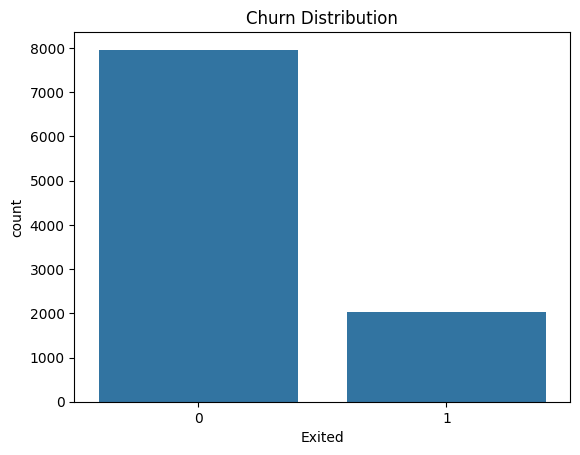

In [27]:
# Step 4: Exploratory Data Analysis
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution")
plt.show()



##### The Above Graph Shows that: 
The dataset is imbalanced:
- Majority (~80%) of customers did not churn.
- Minority (~20%) exited.

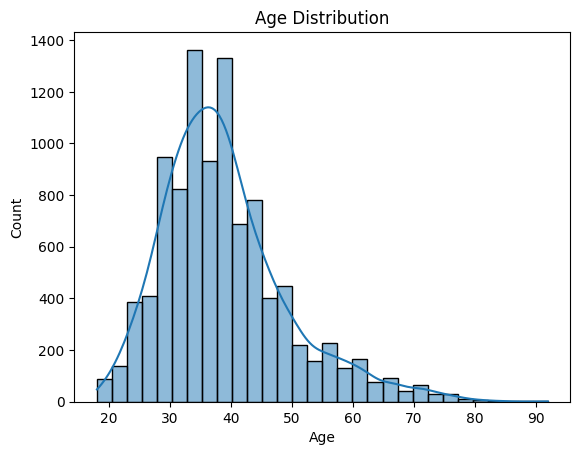

In [28]:
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()



##### The Above Graph Shows that:
Most customers are between 30 and 45 years old.
- Very few are under 20 or over 60.
- The distribution is slightly right-skewed.

Age could play a role in customer churn.


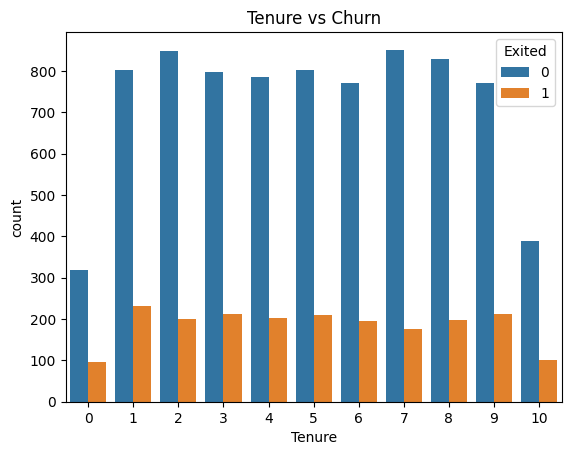

In [29]:
sns.countplot(x='Tenure', hue='Exited', data=df)
plt.title("Tenure vs Churn")
plt.show()



##### The Above Grapsh Shows that:
Churn is fairly uniform across all tenure levels (0–10 years).
- No clear trend of more or less churn at any specific tenure.
- Tenure alone may not be a strong predictor.


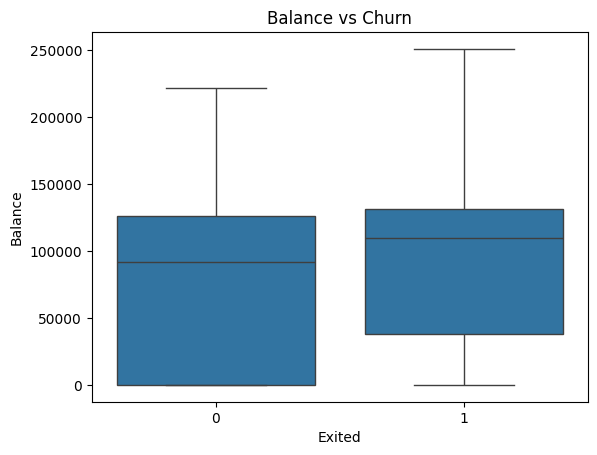

In [30]:
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title("Balance vs Churn")
plt.show()


##### The Above Graph Shows that:
Churners often have **higher account balances** than non-churners.
- Customers with high balances may leave due to poor engagement or service.

Balance appears to be an important feature for churn prediction.

#### Feature Scaling and Train-Test Split

In [31]:

X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model Training Using Different Models

In [32]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

# Gradient Boost
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

#### Model Evaluation

In [33]:

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

Random Forest Accuracy: 0.8665
Logistic Regression Accuracy: 0.811
Gradient Boosting Accuracy: 0.8675

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Confusion Matrix:
 [[1550   57]
 [ 210  183]]


##### Model Accuracy Comparison:

- Random Forest: 86.65% 
- Gradient Boosting: 86.75%  (slightly best)
- Logistic Regression: 81.10%  (lowest)

but we will use Random Forest because it’s simpler, faster, and more interpretable, and the accuracy difference is negligible in this case.

Confusion Matrix:
- 1550 correct non-churn predictions
- 183 correct churn predictions
- 210 churners missed (wrongly predicted as not churn)
- 57 non-churners wrongly predicted as churn

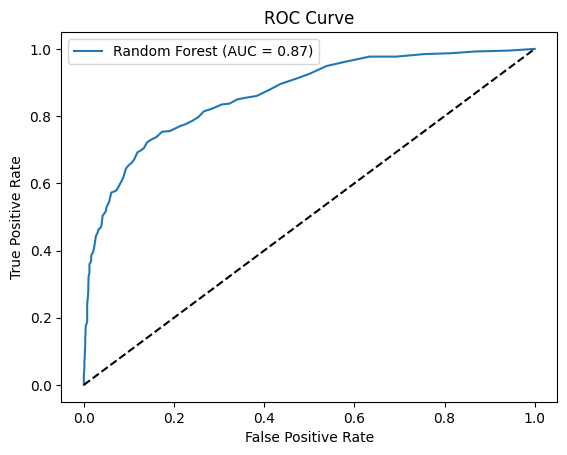

In [34]:
# ROC-AUC Curve (Random Forest)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**ROC Curve – Random Forest**

- ROC curve shows the trade-off between true positive rate and false positive rate.
- AUC score closer to 1 means better model performance.

This Random Forest model has a good AUC score, indicating strong predictive power.


#### Feature Imprortance

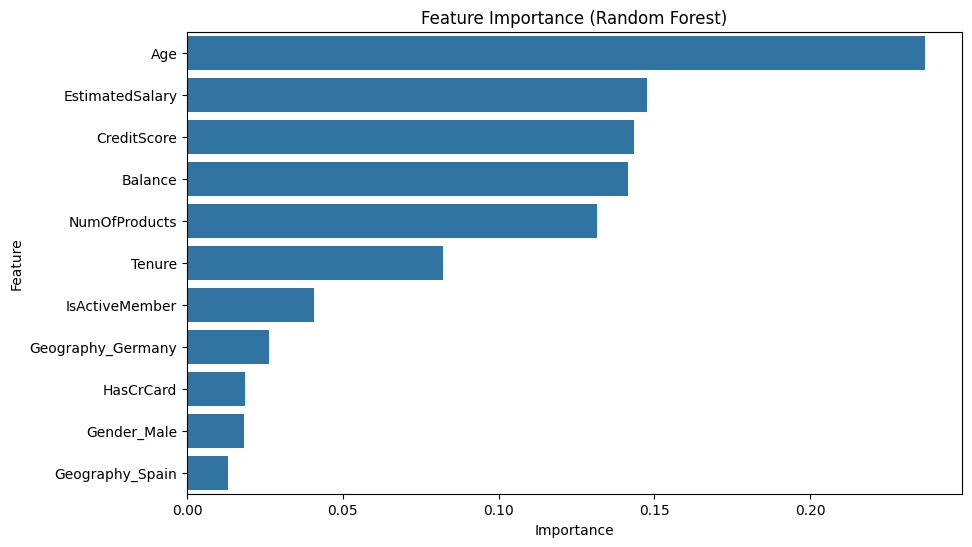

In [35]:
# Feature Importance (Random Forest)
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (Random Forest)")
plt.show()

##### Top features influencing churn:
- **Age** is the most influential feature in this model.
- Other strong predictors include EstimatedSalary, CreditScore, and Balance and Number of Products.
- Features like Geography_Spain, Gender_Male, and HasCrCard have much lower importance
These features are key drivers in the Random Forest model’s decisions.

In [36]:
# Step 10: Save the Final Model
joblib.dump(rf, 'model/churn_rf_model.pkl')

['model/churn_rf_model.pkl']

##  Conclusion

- The **Random Forest** model performed best for churn prediction.
- Key churn indicators: **Age**,**EstimatedSalary**, **Balance**, **CreditScore**, **Activity**, and **Number of Products**.
- Customers with high balance but low activity were more likely to churn.
- This model can help the bank **target at-risk customers** for retention efforts.

### 🔧 TODO: Add XGBoost classifier for comparison

In [ ]:
# Test alternative model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
print("Gradient Boosting Accuracy:", gb_model.score(X_test, y_test))


In [ ]:
# Debug: Visualize missing values
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)
